In [4]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
%matplotlib inline

def get_bootstrap_samples(data, n_samples):
    """ bootstrap """
    
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    """ confint for bootstrap """
    
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [8]:
# 4, непараметрический ранговый критерий для 1d выборки
sample = np.array([49,58,75,110,112,132,151,276,281,362])
m0 = 200
stats.wilcoxon(sample - m0)

WilcoxonResult(statistic=17.0, pvalue=0.28450269791120752)

In [43]:
# 5, непараметрический ранговый критерий для независимых выборок
forest_normal = [22,22,15,13,19,19,18,20,21,13,13,15]
forest_deforestated = [17,18,18,15,12,4,14,15,10]
stats.mannwhitneyu(x=forest_normal, y=forest_deforestated, alternative='greater')

MannwhitneyuResult(statistic=81.0, pvalue=0.029004992720873729)

(array([ 1.,  0.,  0.,  0.,  1.,  1.,  0.,  3.,  0.,  3.]),
 array([  4. ,   5.4,   6.8,   8.2,   9.6,  11. ,  12.4,  13.8,  15.2,
         16.6,  18. ]),
 <a list of 10 Patch objects>)

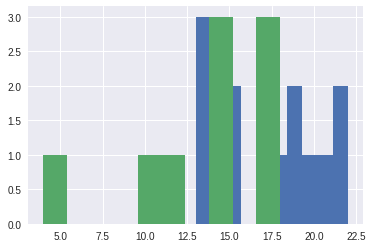

In [44]:
sns.plt.hist(forest_normal)
sns.plt.hist(forest_deforestated)

In [11]:
# 6 challenger 
# бутстреп

np.random.seed(0)

challenger = pd.read_csv('./challenger.txt', '\t')
t_incident = np.array(challenger.Temperature[challenger.Incident==1])
t_ok = np.array(challenger.Temperature[challenger.Incident==0])


bts_incident = get_bootstrap_samples(t_incident, 1000)
bts_ok = get_bootstrap_samples(t_ok, 1000)

bts_incident_mean = bts_incident.mean(1)
bts_ok_mean = bts_ok.mean(1)

stat_intervals(bts_ok_mean - bts_incident_mean, 0.05)

array([ 1.45040179,  8.06457589])

(array([  18.,   68.,  151.,  216.,  247.,  165.,   92.,   34.,    8.,    1.]),
 array([ 20.64375 ,  21.036875,  21.43    ,  21.823125,  22.21625 ,
         22.609375,  23.0025  ,  23.395625,  23.78875 ,  24.181875,  24.575   ]),
 <a list of 10 Patch objects>)

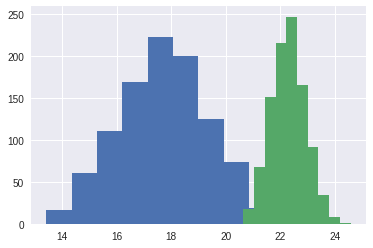

In [12]:
sns.plt.hist(bts_incident_mean)
sns.plt.hist(bts_ok_mean)

In [13]:
# 7 перестановочный тест

def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n2 = len(sample2)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, n2, max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)


In [21]:
np.random.seed(0)
permutation_test(t_incident, t_ok, max_permutations = 10000)

0.0057